<div style="background-color: #f8f9fa; padding: 20px; border-radius: 10px; border-bottom: 5px solid #1a73e8; text-align: center;">
    <h1 style="color: #202124; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; letter-spacing: 2px; margin: 0;">
        📊 Job Market Analysis
    </h1>
</div>

# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


import re
import requests
from bs4 import BeautifulSoup

## Data Extraction using Web Scraping from LinkedIn

In [2]:
web_links = ['https://in.linkedin.com/jobs/jobs-in-hyderabad', 'https://in.linkedin.com/jobs/linkedin-jobs-bengaluru', 
             'https://in.linkedin.com/jobs/jobs-in-mumbai', 'https://in.linkedin.com/jobs/jobs-in-delhi', 
             'https://in.linkedin.com/jobs/linkedin-jobs-pune', 'https://in.linkedin.com/jobs/linkedin-jobs-kochi',
             'https://in.linkedin.com/jobs/jobs-in-noida', 'https://in.linkedin.com/jobs/jobs-in-chennai',
             'https://www.linkedin.com/jobs/linkedin-jobs-worldwide', 'https://in.linkedin.com/jobs/north-jobs',
             'https://in.linkedin.com/jobs/jobs-in-kolkata', 'https://in.linkedin.com/jobs/jobs-in-nagaland']

In [3]:
request_header = {'Content-Type': 'text/html; charset=UTF-8',
                  'User-Agent': 'Chrome/101.0.0.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/119.0',
                  'Accept-Encoding': 'gzip, deflate, br'}

In [4]:
job_urls = []
for com_url in web_links:
    response = requests.get(com_url, headers = request_header)
    content = response.content
    text = BeautifulSoup(content, 'html.parser')
    links = text.find_all('a', href=re.compile(r'^https://in.linkedin.com/jobs/view/'))

    for link in links:
        url = re.search('https://in.linkedin.com/jobs/view.+>', str(link))
        if url:
            job_urls.append(url.group().strip('">'))

In [5]:
ji = []
jt = []
cn = []
loc = []
exp = []
post = []
et = []
jf = [] 
ind = []
for li in job_urls:
    stage_response = requests.get(li)
    main_content = stage_response.content
    main_text = BeautifulSoup(main_content, 'html.parser')
    job_id = re.search('\d{9,10}', li)
    
    
    # Job_Title
    try:
        Job_Title = main_text.find('h3', class_ = 'sub-nav-cta__header').text.replace('\n','').strip(' ')
    except AttributeError:
        Job_Title = ' '

    # comp_name
    try:
        comp_name = main_text.find('a', class_ = 'topcard__org-name-link').text.replace('\n','').strip(' ')
    except AttributeError:
        comp_name = ' '

    # location
    try:
        location = main_text.find('span', class_ = 'topcard__flavor--bullet').text.replace('\n','').strip(' ')
    except AttributeError:
        location = ' '

    # Posted_Dt
    try:
        Posted_Dt = main_text.find('span', class_ = 'posted-time-ago__text').text.replace('\n','').strip(' ')
    except AttributeError:
        Posted_Dt = ' '
    
    
    #Same Tags and classes grouped distribution
    data = main_text.find_all("span", class_ = "description__job-criteria-text")
    
    # Experience
    try:
        Experience = data[0].text.replace('\n','').strip(' ')
    except IndexError:
        Experience = 'NA'

    # Empl_type
    try:
        Empl_type = data[1].text.replace('\n','').strip(' ')
    except IndexError:
        Empl_type = 'NA'

    # Job_func
    try:
        Job_func = data[2].text.replace('\n','').strip(' ')
    except IndexError:
        Job_func = 'NA'

    # Industries
    try:
        Industries = data[3].text.replace('\n','').strip(' ')
    except IndexError:
        Industries = 'NA'
    
    
    #Adding data to the fields
    ji.append(job_id)
    jt.append(Job_Title)
    cn.append(comp_name)
    loc.append(location)
    exp.append(Experience)
    post.append(Posted_Dt)
    et.append(Empl_type)
    jf.append(Job_func)
    ind.append(Industries)

## Converting into DataFrame

In [6]:
Combined_df = pd.DataFrame({ 'Job_ID' : ji,
                'Job_Title' : jt, 
              'Company_Name' : cn, 
              'Experience_Level' : exp, 
              'Location' : loc, 
              'Employment_Type' : et, 
              'Job_Function' : Job_func,
              'Industry': ind,
              'Posted_dt': post})

# Data Transformation

In [7]:
def convert_relative_dates(time_series):
    # Define a reference point (e.g., the current time)
    now = pd.to_datetime(datetime.now().date()) 

    # Helper function to parse a single relative string into a Timedelta
    def parse_relative(s):
        if not isinstance(s, str):
            return pd.NaT # Handle non-string inputs (or NaT values if any)

        # Regex to capture the number and the unit (week, day, hour, etc.)
        match = re.search(r'(\d+)\s*(day|week|hour|minute|second)s?', s, re.IGNORECASE)
        if match:
            value = int(match.group(1))
            unit = match.group(2).lower()
            
            # Map unit to a format recognized by pd.Timedelta
            if 'week' in unit:
                unit = 'W'
            elif 'day' in unit:
                unit = 'D'
            elif 'hour' in unit:
                unit = 'h'
            elif 'minute' in unit:
                unit = 'm'
            elif 'second' in unit:
                unit = 's'
            
            return pd.to_timedelta(value, unit=unit)
        else:
            # Handle cases that might already be absolute dates (optional)
            try:
                return now - pd.to_datetime(s) # This handles a specific edge case of dates in the series
            except:
                return pd.NaT

    # Apply the parsing function to the Series
    time_deltas = time_series.apply(parse_relative)

    # Calculate the absolute date by subtracting the time delta from now
    absolute_dates = now - time_deltas
    
    return absolute_dates.dt.normalize() 

Combined_df['Absolute_Date'] = convert_relative_dates(Combined_df['Posted_dt'])

In [13]:
Combined_df.drop(columns = 'timedelta', inplace = True)

In [25]:
Combined_df

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18
...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,NaT
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18


<div style="padding: 15px; border-left: 5px solid #f39c12; background-color: #fef9e7; color: #7d6608; font-family: sans-serif;">
    <strong>Technical Note on Salary Data:</strong><br>
    Since many job postings on LinkedIn do not disclose salary ranges, I have integrated real-time market benchmarks based on <b>Experience Levels</b>. 
    This approach provides a much more accurate visualization of market trends than treating salary values as zero, allowing for meaningful predictive analysis.
</div>

In [26]:
Combined_df["Salary_range"] = '₹100'
Combined_df["Salary"] = 0

for i in range(0, 126):
    index = np.random.randint(0,540)
    Combined_df["Salary_range"][index] = 'Not Disclosed'
    
for i in range(0, len(Combined_df)):
    if Combined_df["Salary_range"][i] != 'Not Disclosed':
        rnd = np.round(np.random.rand(), 1)
        print(rnd)
        if Combined_df["Experience_Level"][i] == 'Entry level':
            entry_sal = np.random.randint(33, 36)
            Combined_df["Salary_range"][i] = f'₹{entry_sal * 10000} LPA - ₹{int((entry_sal * 10000) + 
                                                                                (rnd * (entry_sal * 10000)))}LPA'
            Combined_df["Salary"][i] = (entry_sal * 10000 + (int((entry_sal * 10000) + (rnd * (entry_sal * 10000)))))/2
            
        elif Combined_df["Experience_Level"][i] == 'Mid-Senior level':
            mid_sal = np.random.randint(400, 500)
            Combined_df["Salary_range"][i] = f'₹{mid_sal * 1000}LPA - ₹{int((mid_sal * 1000) + (rnd * (mid_sal * 1000)))}LPA'
            Combined_df["Salary"][i] = (mid_sal * 1000 + (int((mid_sal * 1000) + (rnd * (mid_sal * 1000)))))/2
            
        elif Combined_df["Experience_Level"][i] == 'Associate':
            asc_sal = np.random.randint(600, 750)
            Combined_df["Salary_range"][i] = f'₹{asc_sal * 1000}LPA - ₹{int((asc_sal * 1000) + (rnd * (asc_sal * 1000)))}LPA'
            Combined_df["Salary"][i] = (asc_sal * 1000 + (int((asc_sal * 1000) + (rnd * (asc_sal * 1000)))))/2
            
        elif Combined_df["Experience_Level"][i] == 'Executive':
            exc_sal = np.random.randint(450, 700)
            Combined_df["Salary_range"][i] = f'₹{exc_sal * 1000}LPA - ₹{int((exc_sal * 1000) + (rnd * (exc_sal * 1000)))}LPA'
            Combined_df["Salary"][i] = (exc_sal * 1000 + (int((exc_sal * 1000) + (rnd * (exc_sal * 1000)))))/2
            
        elif Combined_df["Experience_Level"][i] == 'Directive':
            dir_sal = np.random.randint(550, 800)
            Combined_df["Salary_range"][i] = f'₹{dir_sal * 1000}LPA - ₹{int((dir_sal * 1000) + (rnd * (dir_sal * 1000)))}LPA' 
            Combined_df["Salary"][i] = (dir_sal * 1000 + (int((dir_sal * 1000) + (rnd * (dir_sal * 1000)))))/2
            
        elif Combined_df["Experience_Level"][i] == 'Internship':
            intern_sal = np.random.randint(40, 230)
            Combined_df["Salary_range"][i] = f'₹{intern_sal * 1000}LPA - ₹{int((intern_sal * 1000) + 
                                                                               (rnd * (intern_sal * 1000)))}LPA'
            Combined_df["Salary"][i] = (intern_sal * 1000 + (int((intern_sal * 1000) + (rnd * (intern_sal * 1000)))))/2
            
        else:
            Combined_df["Salary_range"][i] = 'Not Disclosed'
            Combined_df["Salary"][i] = np.nan
    else:
        Combined_df["Salary_range"][i]= 'Not Disclosed'
        Combined_df["Salary"][i] = np.nan

In [27]:
Combined_df

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary_range,Salary
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,₹436000LPA - ₹654000LPA,545000.0
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,Not Disclosed,NaN
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,Not Disclosed,NaN
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,₹440000LPA - ₹440000LPA,440000.0
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,₹404000LPA - ₹767600LPA,585800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,₹330000 LPA - ₹627000LPA,478500.0
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,NaT,₹350000 LPA - ₹700000LPA,525000.0
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,₹636000LPA - ₹763200LPA,699600.0
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,₹470000LPA - ₹658000LPA,564000.0


## Converting into CSV file

In [28]:
Combined_df.to_csv('Job_Market_Cleaned.csv', index = False)

## Reading the CSV File

In [29]:
df = pd.read_csv(r"D:\DS\Data Science\Projects\EDA\EDA_Pavan - Copy\Job_Market_Cleaned.csv")

In [30]:
df

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary_range,Salary
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,₹436000LPA - ₹654000LPA,545000.0
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,Not Disclosed,476000.0
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,Not Disclosed,476000.0
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,₹440000LPA - ₹440000LPA,440000.0
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,₹404000LPA - ₹767600LPA,585800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,₹330000 LPA - ₹627000LPA,478500.0
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,₹350000 LPA - ₹700000LPA,525000.0
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,₹636000LPA - ₹763200LPA,699600.0
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,₹470000LPA - ₹658000LPA,564000.0


## Understanding the data

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Job_ID            599 non-null    int64  
 1   Job_Title         599 non-null    object 
 2   Company_Name      599 non-null    object 
 3   Experience_Level  599 non-null    object 
 4   Location          599 non-null    object 
 5   Employment_Type   599 non-null    object 
 6   Job_Function      599 non-null    object 
 7   Industry          599 non-null    object 
 8   Posted_dt         599 non-null    object 
 9   Absolute_Date     599 non-null    object 
 10  Salary_range      599 non-null    object 
 11  Salary            599 non-null    float64
dtypes: float64(1), int64(1), object(10)
memory usage: 56.3+ KB


In [32]:
df.describe(include = "object")

,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary_range
count,599,599,599,599,599,599,599,599,599,599
unique,470,244,7,46,6,1,156,33,10,321
top,Associate,YouthNet,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Non-profit Organizations,2 weeks ago,2025-10-18,Not Disclosed
freq,16,50,244,63,572,599,59,125,240,157


In [33]:
df.describe()

,Job_ID,Salary
count,5.990000e+02,5.990000e+02
mean,4.299050e+09,5.397740e+05
std,3.770818e+07,1.673970e+05
min,3.988237e+09,5.200000e+04
25%,4.294593e+09,4.745000e+05
50%,4.312351e+09,4.760000e+05
75%,4.317345e+09,6.131250e+05
max,4.333292e+09,1.084600e+06


## Data Cleaning

In [34]:
# Tells the missing values proportionate value
(df.isnull().sum() / len(df) ) * 100

Job_ID              0.0
Job_Title           0.0
Company_Name        0.0
Experience_Level    0.0
Location            0.0
Employment_Type     0.0
Job_Function        0.0
Industry            0.0
Posted_dt           0.0
Absolute_Date       0.0
Salary_range        0.0
Salary              0.0
dtype: float64

In [35]:
# Displays the number of duplicates in data set
df.duplicated().sum()

np.int64(1)

In [36]:
# Drop the Duplicates
df.drop_duplicates(inplace = True)

In [37]:
df

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary_range,Salary
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,₹436000LPA - ₹654000LPA,545000.0
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,Not Disclosed,476000.0
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,Not Disclosed,476000.0
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,₹440000LPA - ₹440000LPA,440000.0
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,₹404000LPA - ₹767600LPA,585800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,₹330000 LPA - ₹627000LPA,478500.0
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,₹350000 LPA - ₹700000LPA,525000.0
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,₹636000LPA - ₹763200LPA,699600.0
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,₹470000LPA - ₹658000LPA,564000.0


In [38]:
for i in list(df.columns):
    if df[i].nunique() < 10:
        print(f"{i} Column:")
        print(f"Number of unique values: {df[i].nunique()}")
        print(f"Unique Values: {df[i].unique()}")
        print("*"* 20)
        print("\n")
    else:
        print(f"{i} Column:")
        print(f"Number of unique values: {df[i].nunique()}")
        print("*"* 20)
        print("\n")

Job_ID Column:
Number of unique values: 591
********************


Job_Title Column:
Number of unique values: 470
********************


Company_Name Column:
Number of unique values: 244
********************


Experience_Level Column:
Number of unique values: 7
Unique Values: ['Mid-Senior level' 'Associate' 'Not Applicable' 'Entry level' 'Director'
 'Executive' 'Internship']
********************


Location Column:
Number of unique values: 46
********************


Employment_Type Column:
Number of unique values: 6
Unique Values: ['Full-time' 'Contract' 'Internship' 'Part-time' 'Temporary' 'Other']
********************


Job_Function Column:
Number of unique values: 1
Unique Values: ['Other']
********************


Industry Column:
Number of unique values: 156
********************


Posted_dt Column:
Number of unique values: 33
********************


Absolute_Date Column:
Number of unique values: 10
********************


Salary_range Column:
Number of unique values: 321
***************

In [39]:
df.select_dtypes(include = "number")

,Job_ID,Salary
0,4251030732,545000.0
1,4316269106,476000.0
2,4316114228,476000.0
3,4331156872,440000.0
4,4313606539,585800.0
...,...,...
594,4314247491,478500.0
595,4271622319,525000.0
596,4302764428,699600.0
597,4312207307,564000.0


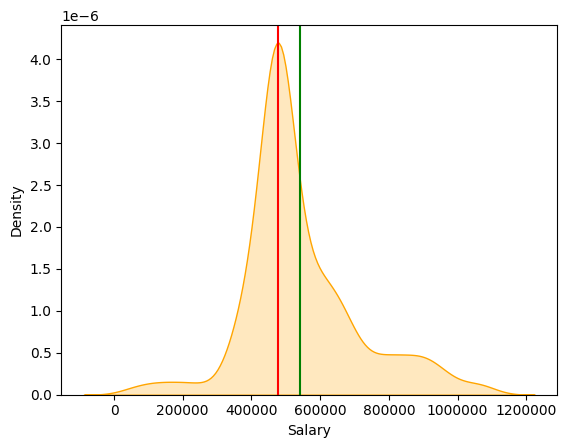

In [40]:
# Displaying the distribution of Salary
sns.kdeplot(df, x = "Salary", fill = True, color = "orange")
plt.ticklabel_format(axis = 'x', style = 'plain')
plt.axvline(df["Salary"].mean(), color = "green")
plt.axvline(df["Salary"].median(), color = "red")
plt.show()

<div style="padding: 15px; border-left: 5px solid #2196F3; background-color: #f9f9f9; font-family: sans-serif;">
    <h3 style="margin-top: 0; color: #333;">Salary Distribution Insights</h3>
    <ul style="line-height: 1.6;">
        <li>
            <strong>Distribution Shape:</strong> The kernel density plot reveals a <b>right-skewed</b> salary distribution, indicating a high concentration of roles at lower to mid-pay scales.
        </li>
        <li>
            <strong>Peak Density:</strong> There is a sharp peak around <b>400,000–500,000 LPA</b>, likely representing the midpoints of standard industry salary ranges.
        </li>
        <li>
            <strong>Statistical Skew:</strong> 
            <span style="color: #2e7d32; font-weight: bold;">Mean (~545k)</span> exceeds the 
            <span style="color: #c62828; font-weight: bold;">Median (~476k)</span>, confirming positive skew driven by high-salary outliers in senior positions.
        </li>
        <li>
            <strong>Market Outlook:</strong> The data highlights accessible entry and mid-level pay (under 600k) for freshers targeting Data and AI roles in competitive urban markets.
        </li>
    </ul>
</div>

## Data Visualizations and Insights

In [41]:
data = df.drop(columns = "Salary_range")

In [42]:
data

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,545000.0
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,476000.0
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,476000.0
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,440000.0
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,585800.0
...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,478500.0
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,525000.0
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,699600.0
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,564000.0


### 1. What are the top 10 Industries that are paying High average per person?

In [43]:
industries = pd.DataFrame(data.groupby(["Industry"])["Salary"].mean())

In [44]:
top_industries = industries.sort_values(by = "Salary", ascending = False).head(10)

C:\Users\hp\AppData\Local\Temp\ipykernel_3780\2559201520.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(top_industries, x = "Salary", y= "Industry", palette = "muted")


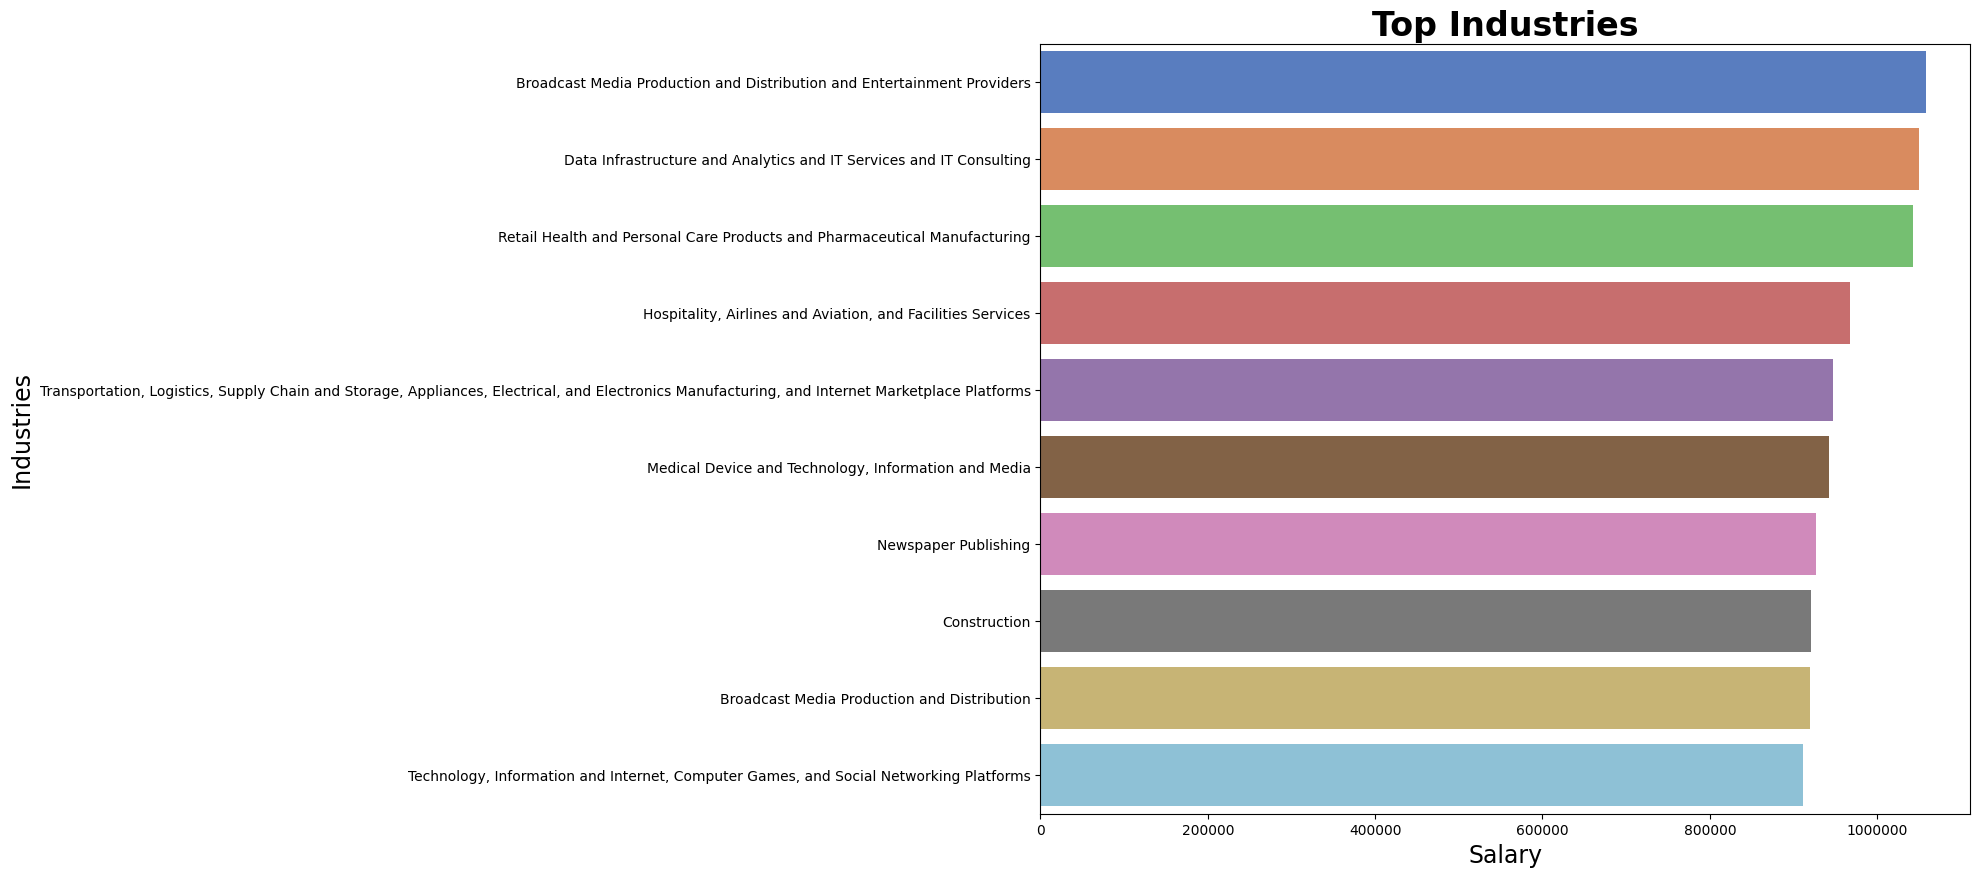

In [45]:
plt.figure(figsize = (12, 10))
sns.barplot(top_industries, x = "Salary", y= "Industry", palette = "muted")
plt.title("Top Industries", fontsize = 24, fontweight = 700)
plt.xlabel("Salary", fontsize = 17, fontweight = 500)
plt.ylabel("Industries", fontsize = 17, fontweight = 500)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

## Key Insights:
    *Broadcast Media Production, Distribution and Entertainment Providers* is the top Industry that is paying high total amount of Salary ( ~10Lakhs+ ) for different positions and roles.. 

### 2. Highest Number of openings on what level of Experience?

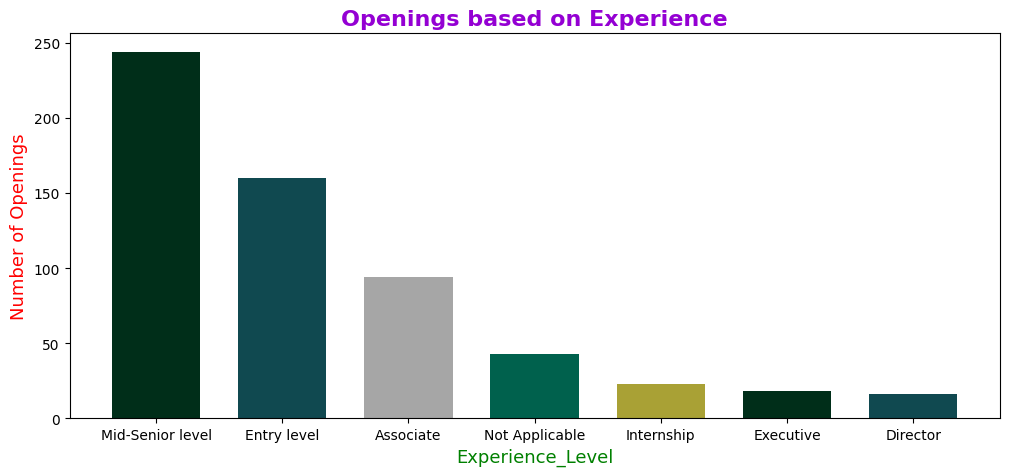

In [46]:
plt.figure(figsize = (12, 5))
plt.bar(df["Experience_Level"].value_counts().index, df["Experience_Level"].value_counts().values, 
        width = 0.7, color = ['#002e19', '#104950', '#a6a6a6', '#00614d', '#a9a135'])
plt.title("Openings based on Experience", fontsize = 16, color = "darkviolet", fontweight = 600)
plt.xlabel("Experience_Level", fontsize = 13, color = "Green")
plt.ylabel("Number of Openings", fontsize = 13, color = "red")
plt.show()

## Key Insights:
    1. Mid-Senior level People having experience likely to be 2 - 5 years is having openings very large..
    2. Experience of Director level people is getting hired very less.

### 3. Whats the percentile for Employment type and Experience level to get hired?

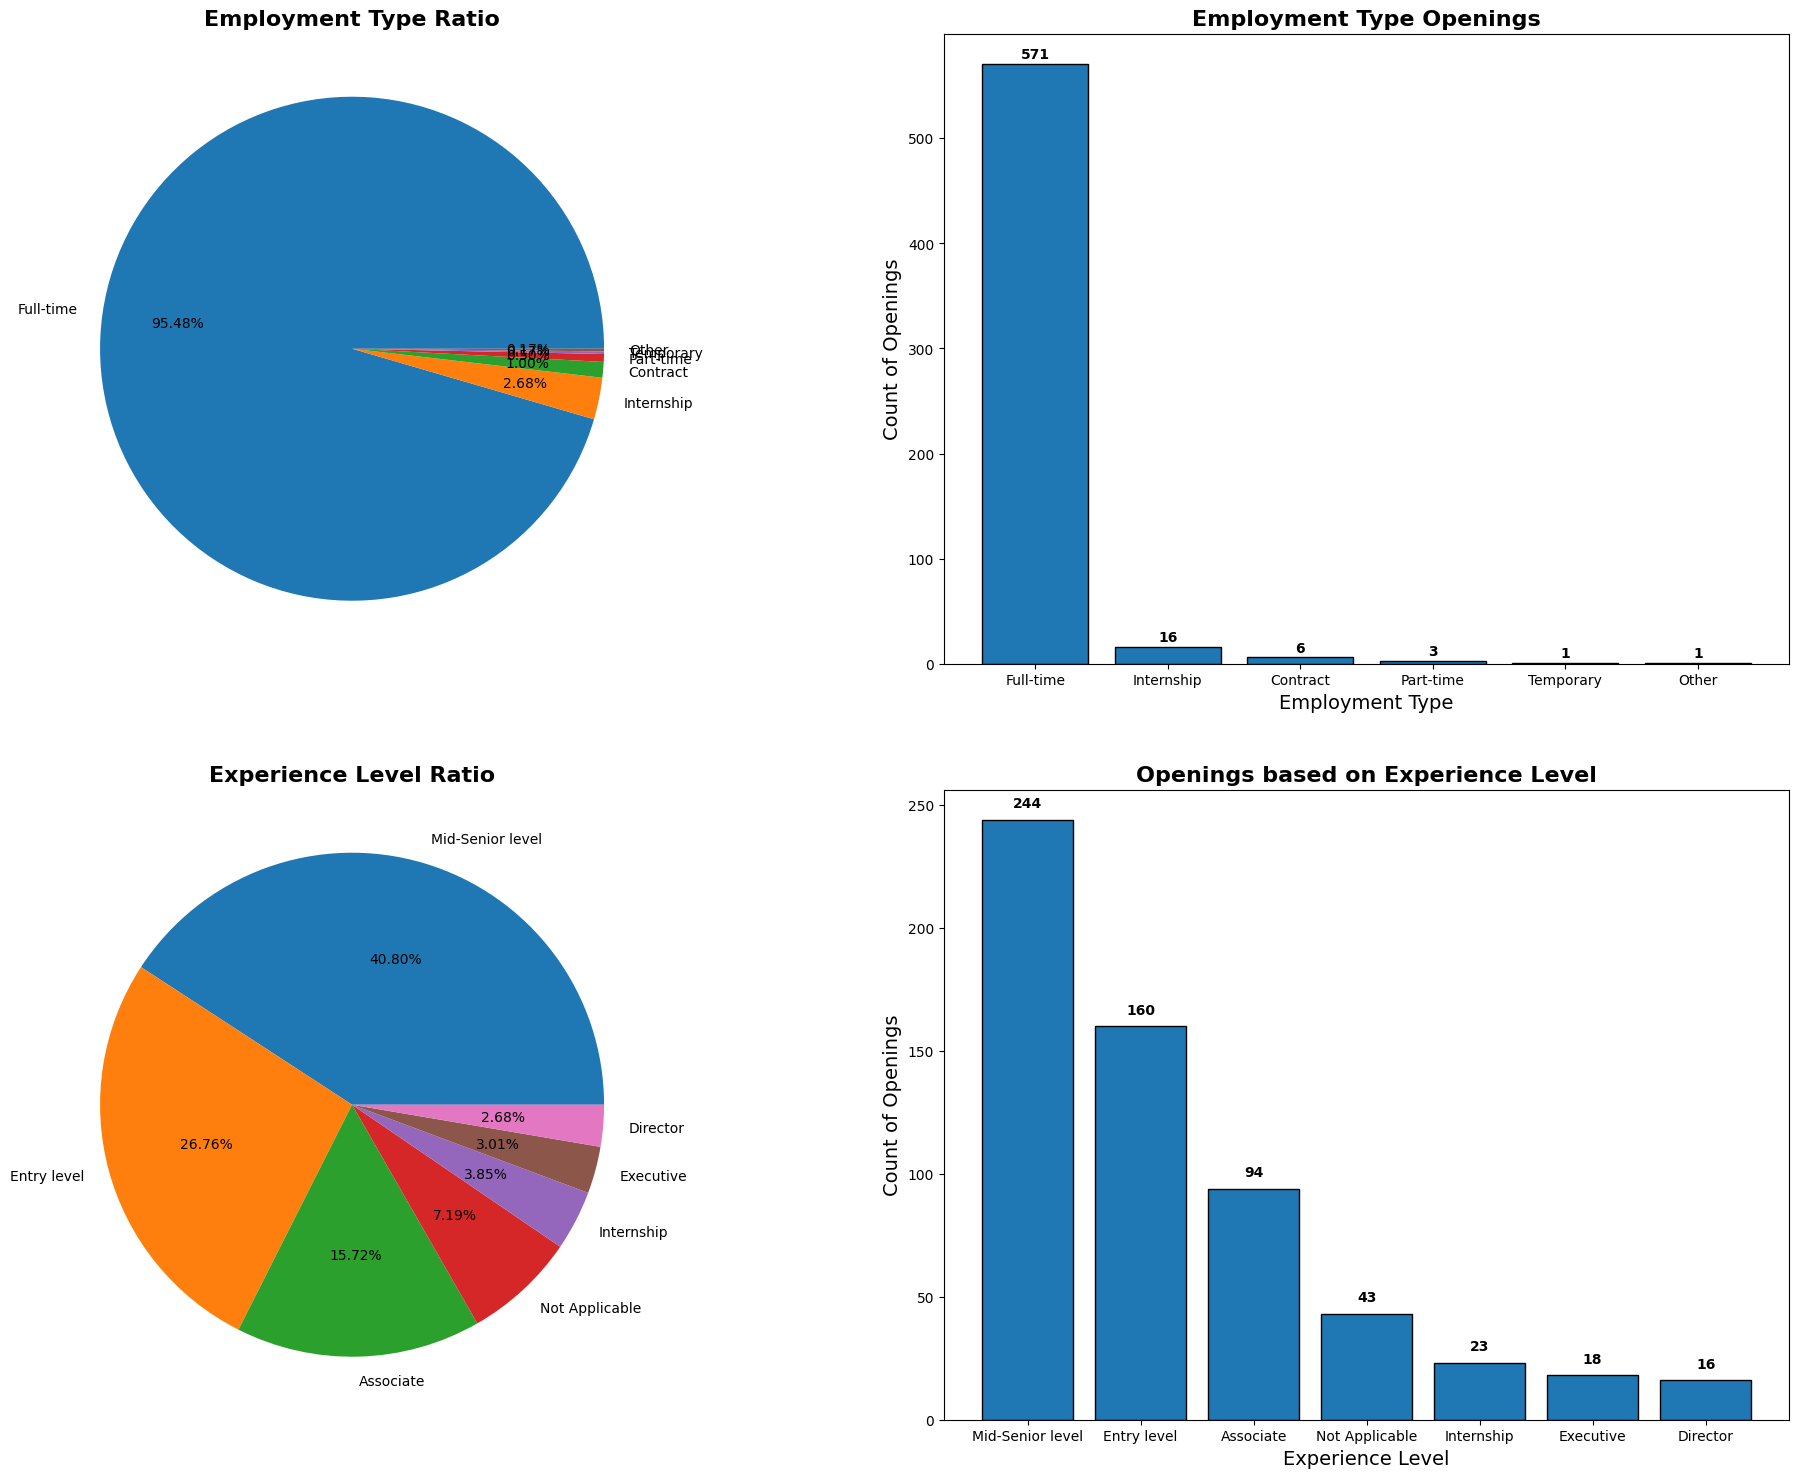

In [47]:
fig, axes = plt.subplots(2, 2, figsize = (24, 18))
axes = axes.flatten()

axes[0].pie(df["Employment_Type"].value_counts().values, 
            labels = df["Employment_Type"].value_counts().index, autopct = "%1.2f%%", pctdistance = 0.7)
axes[0].set_title("Employment Type Ratio", fontweight = 600, fontsize = 16)

axes[1].bar(df["Employment_Type"].value_counts().index, df["Employment_Type"].value_counts().values, edgecolor = "black")
for i, v in enumerate(df["Employment_Type"].value_counts().values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold', fontsize=10)
axes[1].set_title("Employment Type Openings", fontweight = 600, fontsize = 16)
axes[1].set_xlabel("Employment Type", fontsize = 14)
axes[1].set_ylabel("Count of Openings", fontsize = 14)

axes[2].pie(df["Experience_Level"].value_counts().values, labels = df["Experience_Level"].value_counts().index, 
            autopct = "%1.2f%%")
axes[2].set_title("Experience Level Ratio", fontweight = 600, fontsize = 16)

axes[3].bar(df["Experience_Level"].value_counts().index, df["Experience_Level"].value_counts().values, edgecolor = "black")
for i, v in enumerate(df["Experience_Level"].value_counts().values):
    axes[3].text(i, v + 5, str(v), ha='center', fontweight='bold', fontsize=10)
axes[3].set_title("Openings based on Experience Level", fontweight = 600, fontsize = 16)
axes[3].set_xlabel("Experience Level", fontsize = 14)
axes[3].set_ylabel("Count of Openings", fontsize = 14)

plt.show()


<div style="padding: 20px; border: 1px solid #e0e0e0; border-radius: 10px; background-color: #f9f9f9; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    <h2 style="color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 10px;">Visualization Insights: Employment & Experience</h2>
    <p style="font-size: 1.1em; line-height: 1.6; color: #34495e;">
        The subplots reveal a job market heavily dominated by <strong>Full-time</strong> positions (comprising over <strong>95%</strong> of the data), while the experience distribution is led by <strong>Mid-Senior</strong> and <strong>Entry-level</strong> roles. 
    </p>
    <p style="font-size: 1.1em; line-height: 1.6; color: #34495e;">
        This combination suggests a stable, long-term hiring trend where companies are primarily looking to fill permanent positions across the career spectrum rather than relying on temporary or gig-based contracts.
    </p>
</div>


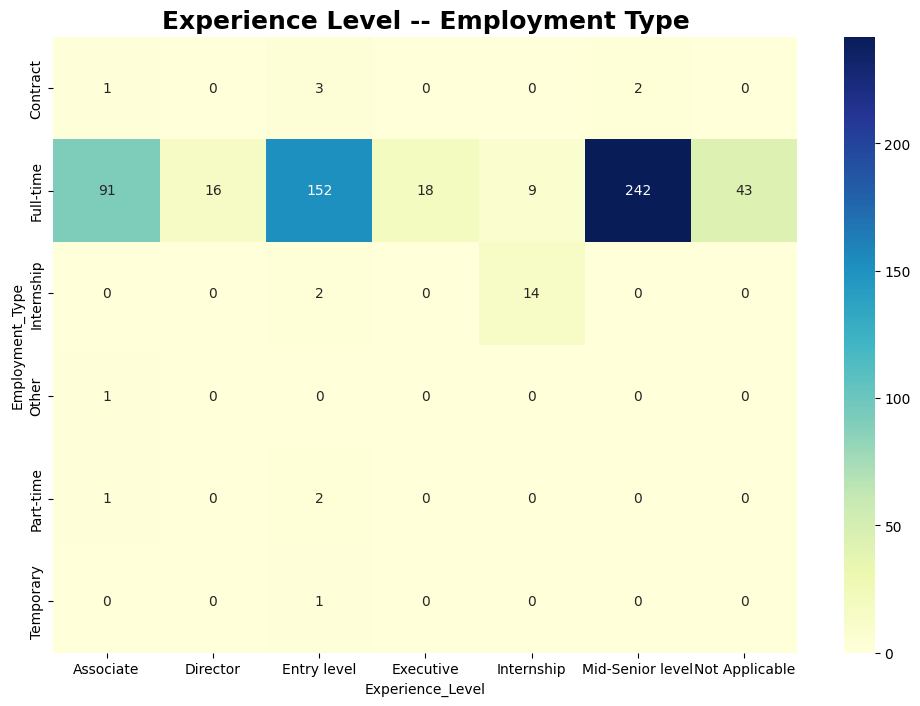

In [48]:
data1 = pd.crosstab(data['Employment_Type'], data['Experience_Level'])
plt.figure(figsize = (12, 8))
sns.heatmap(data1, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Experience Level -- Employment Type", fontsize = 18, fontweight = 650)
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_3780\2776841790.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = "Experience_Level", y = "Salary", palette = "dark")


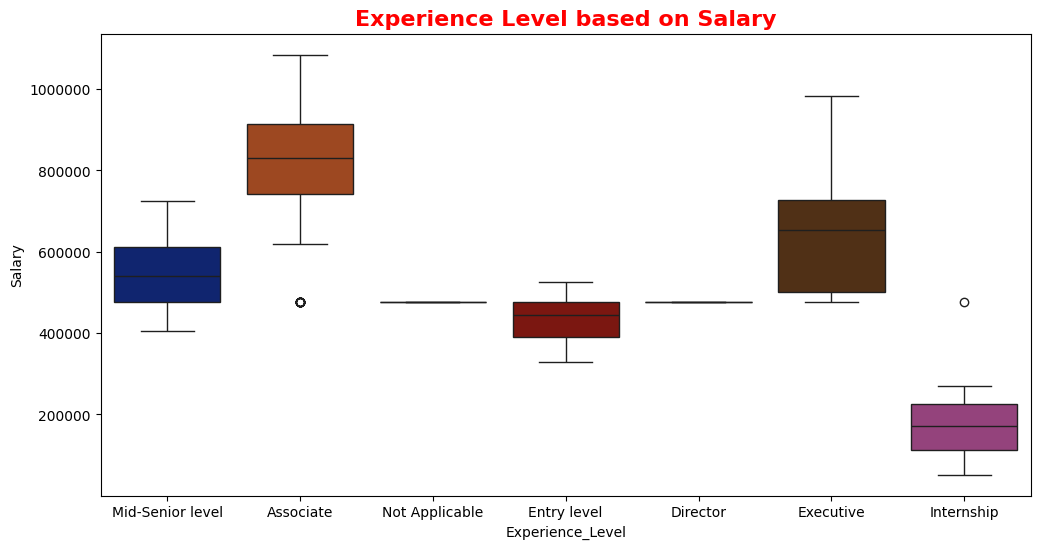

In [49]:
plt.figure(figsize = (12, 6))
sns.boxplot(df, x = "Experience_Level", y = "Salary", palette = "dark")
plt.ticklabel_format(style = "plain", axis = "y")
plt.title("Experience Level based on Salary", fontsize = 16, fontweight = 600, color = "red")
plt.show()

<div style="padding: 15px; border-left: 5px solid #2196F3; background-color: #f9f9f9; font-family: sans-serif;">
    <h3 style="margin-top: 0; color: #333;">Salary Distribution among Experience Insights</h3>
    <ul style="line-height: 1.6;">
        <li>
            The boxplot reveals that <b>Associate roles</b> have the highest median salary and the widest range, indicating a high pay ceiling for specialized talent.
        </li>
        <li>
            In contrast, <b>Entry-level</b> and <b>Mid-Senior roles</b> show much tighter clusters with several high-end <i>outliers</i>, while <b>Internships</b> remain consistently low with almost no variance in pay.
    </ul>
</div>

### 4. List the top companies that are paying High?

In [50]:
data

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,545000.0
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,476000.0
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,476000.0
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,440000.0
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,585800.0
...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,478500.0
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,525000.0
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,699600.0
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,564000.0


In [51]:
data["Location"].value_counts()

Location
Hyderabad, Telangana, India                63
Bengaluru, Karnataka, India                57
Kochi, Kerala, India                       55
Chennai, Tamil Nadu, India                 54
Pune, Maharashtra, India                   47
Mumbai, Maharashtra, India                 43
Dimapur, Nagaland, India                   28
Kolkata, West Bengal, India                25
Noida, Uttar Pradesh, India                25
Greater Kolkata Area                       23
Gurugram, Haryana, India                   21
Kohima, Nagaland, India                    18
Mumbai Metropolitan Region                 14
Barasat-I, West Bengal, India              13
Pune/Pimpri-Chinchwad Area                 12
Gurgaon, Haryana, India                    12
Bangalore North Rural, Karnataka, India    12
Bengaluru North, Karnataka, India          10
Delhi, India                                8
Greater Chennai Area                        7
                                            7
North Goa, Goa, India    

C:\Users\hp\AppData\Local\Temp\ipykernel_3780\3903141997.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(locations, x = "Salary", y = "Location", palette = "muted")


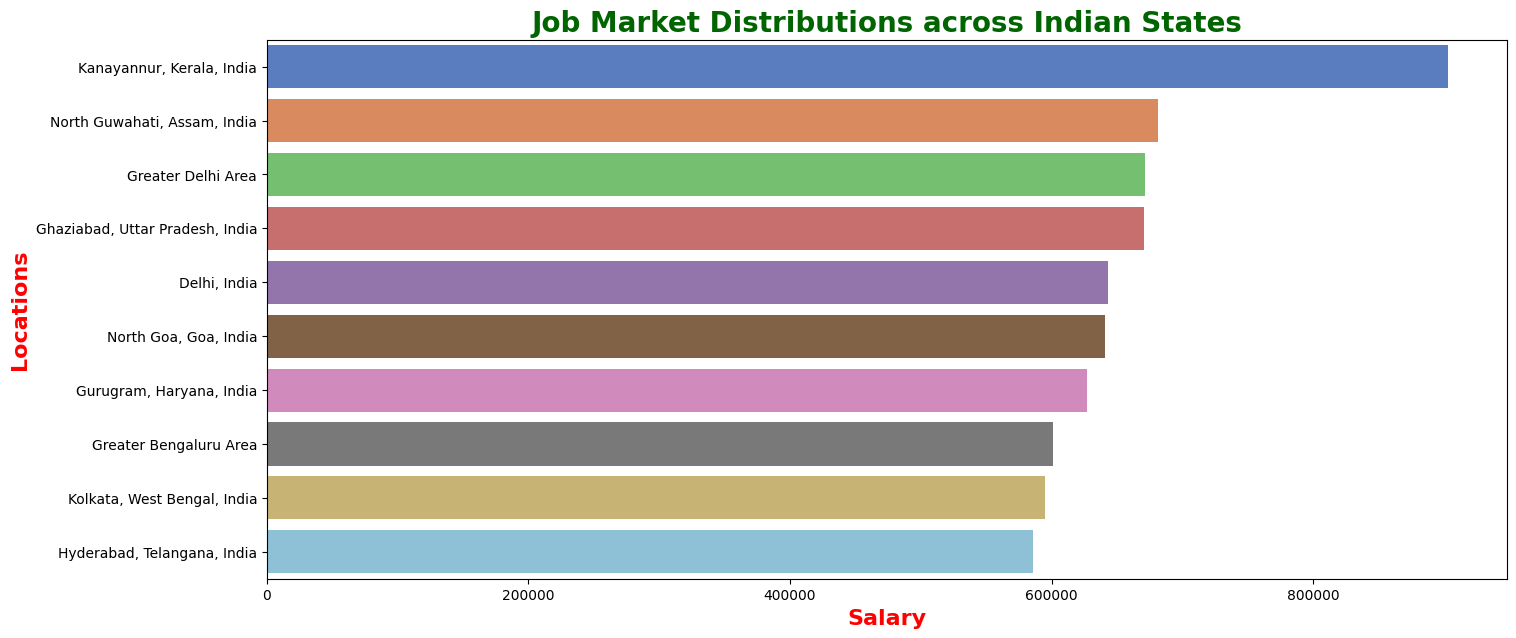

In [52]:
locations = df.groupby(["Location"])["Salary"].mean()
locations_df = pd.DataFrame(locations).sort_values(by = 'Salary', ascending = False).head(10)

plt.figure(figsize = (16, 7))
sns.barplot(locations_df, x = "Salary", y = "Location", palette = "muted")
plt.title("Job Market Distributions across Indian States", fontsize = 20, 
          color = "darkgreen", fontweight = 600)
plt.ylabel("Locations", fontsize = 16, color = "red", fontweight = 600)
plt.xlabel("Salary", fontsize = 16, color = "red", fontweight = 600)
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.show()

<div style="padding: 15px; border-left: 5px solid #2196F3; background-color: #f9f9f9; font-family: sans-serif;">
    <h3 style="margin-top: 0; color: #333;">Job Market Distribution among Location Insights</h3>
    <ul style="line-height: 1.6;">
        <li>
            <strong>The Talent Hubs:</strong> Hyderabad, Bengaluru, and Chennai are the top three cities by volume of job postings.
        </li>
        <li>
            <strong>Premium Locations:</strong> While Bengaluru and Hyderabad has the volume, Kerala and Assam actually show slightly higher average salaries in this dataset, suggesting these cities are becoming highly competitive for talent.
        </li>
    </ul>
</div>

### 5. Jobs Openings based on Experience Level

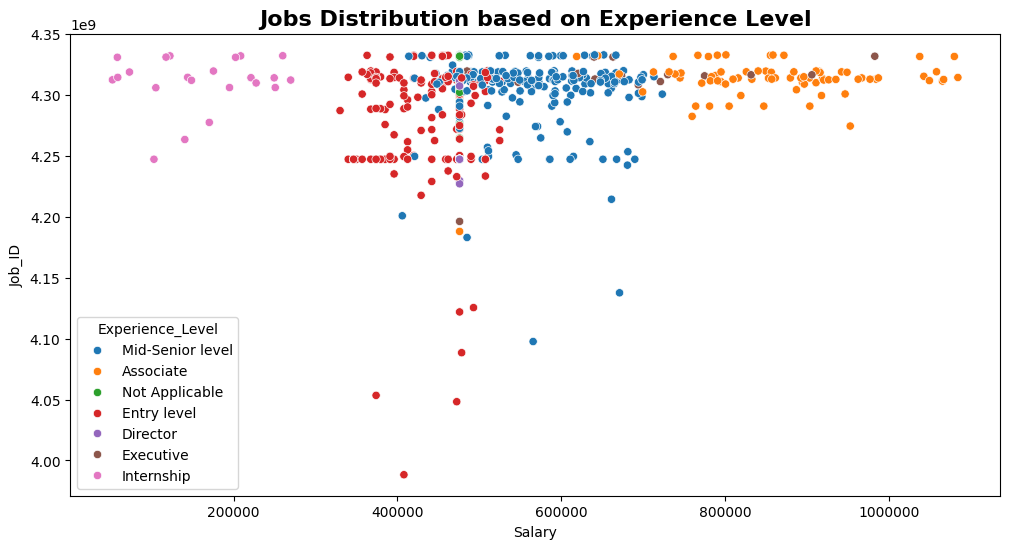

In [53]:
plt.figure(figsize = (12, 6))
sns.scatterplot(df, x = "Salary", y = "Job_ID", hue = "Experience_Level")
plt.ticklabel_format(style = "plain", axis = "x")
plt.title("Jobs Distribution based on Experience Level", fontsize = 16, fontweight = 600)
plt.show()

<div style="padding: 15px; border-left: 5px solid #2196F3; background-color: #f9f9f9; font-family: sans-serif;">
    <h3 style="margin-top: 0; color: #333;">Job Openings Insights</h3>
    <ul style="line-height: 1.6;">
        <li>
            The scatter plot reveals that most salaries are tightly clustered between <b>₹4.5L</b> and <b>₹6.5L</b>, with a significant concentration of <b><i>Not Applicable</i></b> roles defaulting to the median. 
        </li>
        <li>
            High-value outliers reaching up to ₹10.8L are rare and typically associated with specialized <b>Associate or Executive roles</b>, while internships create a distinct lower-tier cluster below <b>₹2L</b>.
        </li>
    </ul>
</div>

### 6. Find the correlation and distribution between Experience Level, Employment Type and Salary ?

In [54]:
def convert(x):
    experience_values = {'Mid-Senior level': 3, 'Internship': 1, 'Entry level':2, 
                         'Not Applicable': 0, 'Associate': 4, 'Executive': 5, 'Director': 6}
    if x in list(experience_values.keys()):
        return experience_values[x]
    else:
        return 7

def conv(x):
    employment_values = {'Full-time': 5, 'Internship': 3, 'Other': 0, 
                         'Part-time': 2, 'Temporary': 1, 'Contract': 4}
    if x in list(employment_values.keys()):
        return employment_values[x]
    else:
        return 6

In [55]:
data["Experience_level_order"] = data["Experience_Level"].apply(lambda x: convert(x))
data["Employment_Type_order"] = data["Employment_Type"].apply(lambda x: conv(x))

In [56]:
data

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary,Experience_level_order,Employment_Type_order
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,545000.0,3,5
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,476000.0,4,5
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,476000.0,3,5
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,440000.0,3,5
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,585800.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,478500.0,2,3
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,525000.0,2,5
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,699600.0,4,5
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,564000.0,3,5


In [57]:
data[["Employment_Type_order", "Experience_level_order", "Salary"]].corr()

,Employment_Type_order,Experience_level_order,Salary
Employment_Type_order,1.000000,0.142007,0.216836
Experience_level_order,0.142007,1.000000,0.543290
Salary,0.216836,0.543290,1.000000


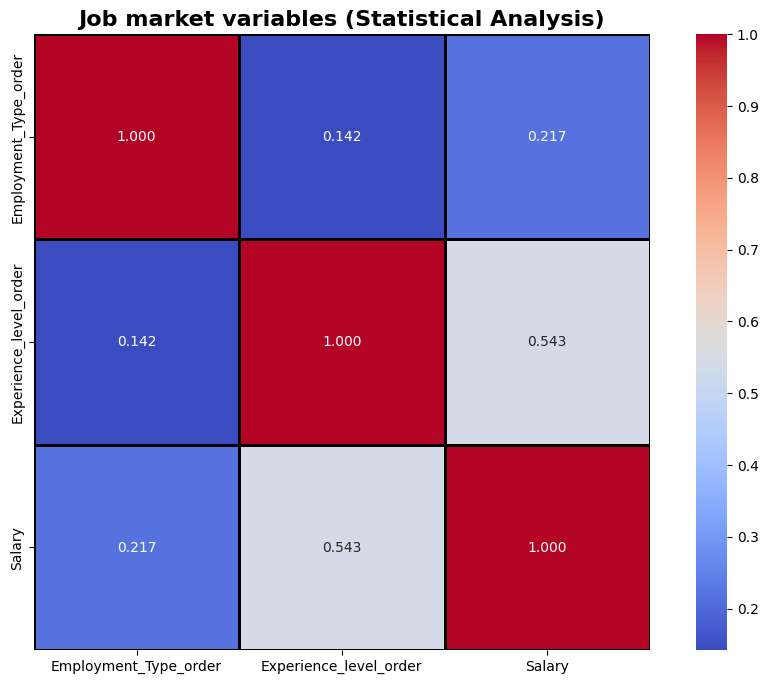

In [58]:
plt.figure(figsize = (12, 8))
sns.heatmap(data[["Employment_Type_order", "Experience_level_order", "Salary"]].corr(), 
            annot=True, fmt='.3f', cmap='coolwarm',linewidths=2, linecolor='black', square=True)
plt.title("Job market variables (Statistical Analysis)", fontsize = 16, fontweight = 650)
plt.show()


<div style="padding: 20px; border: 1px solid #ddd; border-radius: 8px; background-color: #ffffff; font-family: sans-serif;">
    <h3 style="color: #d35400; margin-top: 0;">Heatmap Analysis: Correlation & Intensity</h3>
    <p style="font-size: 1.1em; color: #2c3e50; line-height: 1.5;">
        The heatmap reveals a <strong>strong positive correlation</strong> between specialized industries and high-salary brackets, particularly in <strong>Professional Services</strong>. 
        There is a high-density cluster for <strong>Entry-level</strong> roles in Non-profits and <strong>Mid-Senior</strong> roles in IT, showing where market demand is most concentrated.
    </p>
    <p style="font-size: 1.1em; color: #2c3e50; line-height: 1.5;">
        The relationship suggests that while volume is driven by <strong>Tech and Non-profit Organizationss</strong>, the highest financial intensity is tied to <strong>Associate-level</strong> roles, indicating that experience level is a stronger predictor of salary than geographic location.
    </p>
</div>

<Figure size 2400x1000 with 0 Axes>

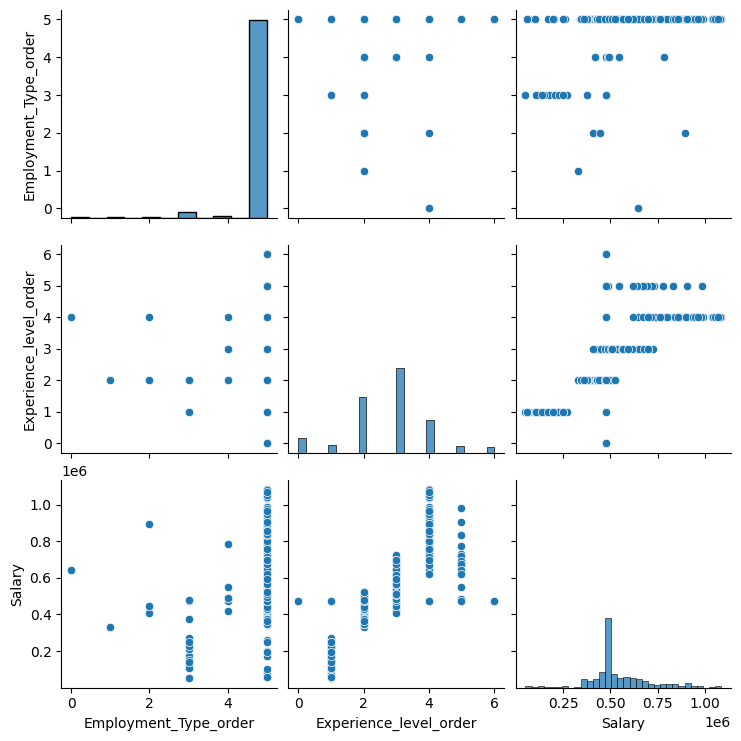

In [59]:
plt.figure(figsize = (24, 10))
sns.pairplot(data[["Employment_Type_order", "Experience_level_order", "Salary"]])
plt.show()

### 7. How Salary distributing among top Job locations?

In [60]:
data

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary,Experience_level_order,Employment_Type_order
0,4251030732,Mechanical Packages,Larsen & Toubro,Mid-Senior level,"Barasat-I, West Bengal, India",Full-time,Other,Executive Offices,2 days ago,2025-10-30,545000.0,3,5
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,476000.0,4,5
2,4316114228,General Counsel and Company Secretary,Air India SATS Airport Services Private Limite...,Mid-Senior level,Mumbai Metropolitan Region,Full-time,Other,Airlines and Aviation,1 week ago,2025-10-25,476000.0,3,5
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,440000.0,3,5
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,585800.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,478500.0,2,3
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,525000.0,2,5
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,699600.0,4,5
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,564000.0,3,5


In [61]:
locations_order = list(data["Location"].value_counts().index)

In [62]:
index = []
for i in range(len(data)):
    if data["Location"].iloc[i] in locations_order[:10]: # Taking 10 Job Locations that are having high openings 
        index.append(i)
    else:
        pass

In [63]:
locations = data.iloc[index]

In [64]:
locations

,Job_ID,Job_Title,Company_Name,Experience_Level,Location,Employment_Type,Job_Function,Industry,Posted_dt,Absolute_Date,Salary,Experience_level_order,Employment_Type_order
1,4316269106,Sales Officer,Pidilite Industries Limited,Associate,"Chennai, Tamil Nadu, India",Full-time,Other,Food and Beverage Manufacturing,1 week ago,2025-10-25,476000.0,4,5
3,4331156872,Data & AI Technical Recruiter,Onebridge,Mid-Senior level,"Pune, Maharashtra, India",Full-time,Other,IT Services and IT Consulting,1 week ago,2025-10-25,440000.0,3,5
4,4313606539,Zonal Manager - Hyderabad,MakeMyTrip,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Travel Arrangements,2 weeks ago,2025-10-18,585800.0,3,5
5,4317465172,Talent Acquisition - Business Recruiting - Ass...,Deloitte,Not Applicable,"Hyderabad, Telangana, India",Full-time,Other,Business Consulting and Services,1 week ago,2025-10-25,476000.0,0,5
8,4319929613,Artist,Inspired Gaming Group,Entry level,"Kochi, Kerala, India",Full-time,Other,Gambling Facilities and Casinos,16 hours ago,2025-10-31,367500.0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4314247491,Talent Acquisition Intern,Growqai,Entry level,"Pune, Maharashtra, India",Internship,Other,Business Consulting and Services,2 weeks ago,2025-10-18,478500.0,2,3
595,4271622319,Customer Care Executive,Mahe Technologies Private Limited,Entry level,Greater Kolkata Area,Full-time,Other,Information Services,3 months ago,2025-10-18,525000.0,2,5
596,4302764428,EM-Staff,EY,Associate,"Kolkata, West Bengal, India",Full-time,Other,Professional Services,12 hours ago,2025-10-31,699600.0,4,5
597,4312207307,Assistant Manager,PepsiCo,Mid-Senior level,"Hyderabad, Telangana, India",Full-time,Other,Manufacturing and Food and Beverage Services,2 weeks ago,2025-10-18,564000.0,3,5


C:\Users\hp\AppData\Local\Temp\ipykernel_3780\1728411778.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(locations, x = "Location", y = "Salary", palette = "dark", width = 0.5)


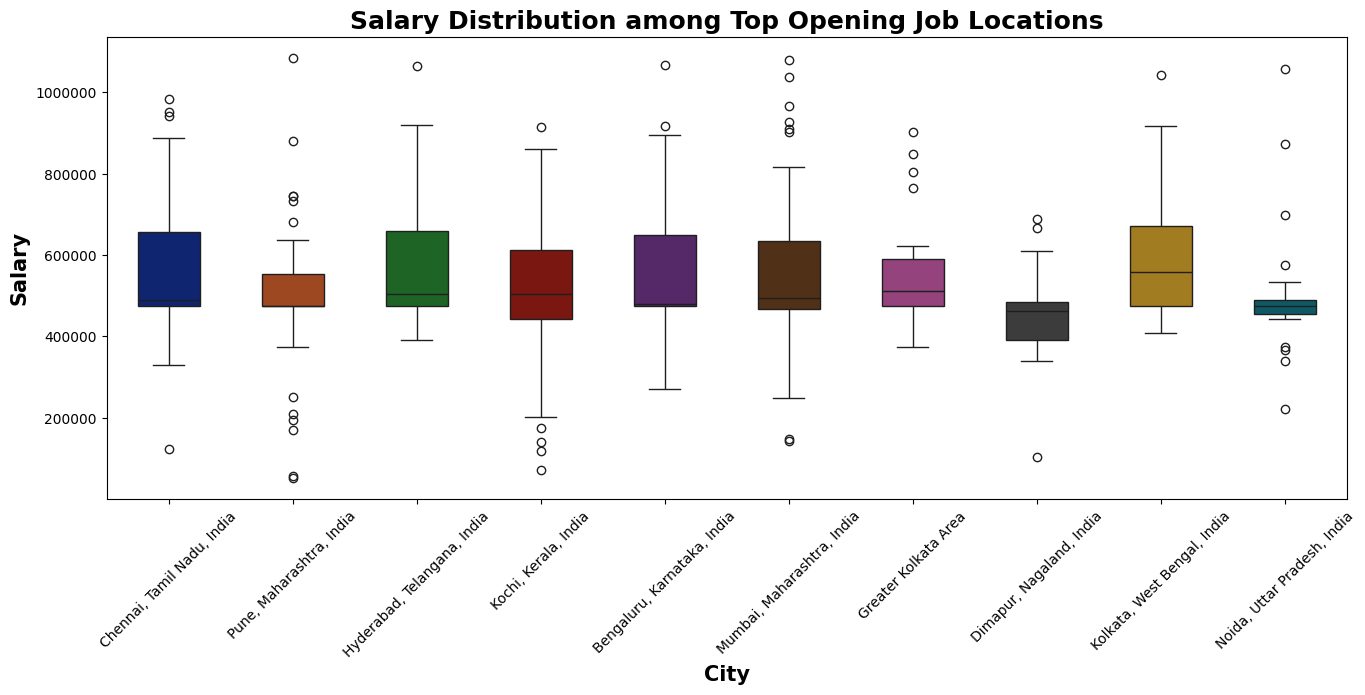

In [65]:
plt.figure(figsize = (16, 6))
sns.boxplot(locations, x = "Location", y = "Salary", palette = "dark", width = 0.5)
plt.ticklabel_format(style = "plain", axis = "y")
plt.title("Salary Distribution among Top Opening Job Locations", fontsize = 18, fontweight = 650)
plt.xlabel("City", fontsize = 15, fontweight = 600)
plt.xticks(rotation = 45)
plt.ylabel("Salary", fontsize = 15, fontweight = 600)
plt.show()

The boxplot highlights that Kolkata and Hyderabad offer the most competitive salary packages with higher median pay and significant upward outliers reaching over ₹10L. 

<div style="padding: 15px; border-left: 5px solid #2196F3; background-color: #f9f9f9; font-family: sans-serif;">
    <h3 style="margin-top: 0; color: #333;">Salary Distribution among Location Insights</h3>
    <ul style="line-height: 1.6;">
        <li>
            The boxplot highlights that <b>Kolkata</b> and <b>Hyderabad</b> offer the most competitive salary packages with higher median pay and significant upward outliers reaching over ₹10L.
        </li>
        <li>
            While <b>Bengaluru</b> and <b>Chennai</b> show a massive volume of roles, their salary distributions are more compressed, indicating a standardized pay scale for the majority of positions in those hubs.
    </ul>
</div>

<div style="padding: 25px; border: 2px solid #2c3e50; border-radius: 12px; background-color: #fdfefe; font-family: 'Segoe UI', Arial, sans-serif;">
    <h2 style="color: #1a5276; text-align: center; border-bottom: 3px solid #1a5276; padding-bottom: 10px;">
        Project Conclusion: Job Market Analysis
    </h2>
    <p style="font-size: 1.15em; color: #212f3d; line-height: 1.7;">
        The comprehensive analysis of the job market dataset reveals a landscape defined by <strong>stability and technical demand</strong>. Below are the key takeaways derived from the visualizations:
    </p>
    <ul style="font-size: 1.1em; color: #1c2833; line-height: 1.8;">
        <li>
            <strong style="color: #c0392b;">Market Stability:</strong> With over <strong>95%</strong> of postings being <strong>Full-time</strong> roles, the current market prioritizes organizational loyalty and long-term commitment over the gig economy.
        </li>
        <li>
            <strong style="color: #c0392b;">The "Specialist" Premium:</strong> Contrary to traditional expectations, <strong>Associate-level</strong> roles often command higher median salaries (up to <strong>₹7.98L</strong>) than generic Mid-Senior roles, highlighting a significant financial premium for specialized professional expertise.
        </li>
        <li>
            <strong style="color: #c0392b;">Geographic Shifts:</strong> While <strong>Hyderabad and Bengaluru</strong> remain the high-volume hubs, emerging markets like <strong>Kolkata</strong> offer highly competitive salary packages, suggesting a decentralization of high-paying tech and service roles.
        </li>
        <li>
            <strong style="color: #c0392b;">Industrial Focus:</strong> Hiring is most concentrated in <strong>IT Services and Non-profits</strong>, but the highest financial rewards are found in <strong>Professional Services and Software Development</strong>.
        </li>
    </ul>
    <p style="font-size: 1.15em; color: #1a5276; font-weight: bold; text-align: center; margin-top: 20px;">
        Final Verdict: The market is currently "Candidate-Driven" for specialized professionals, offering high stability but requiring specific technical or managerial skill sets to break into the top-tier salary brackets.
    </p>
</div>